In [247]:
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import zuko
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from scripts.utils import sinkhorn, MMDLoss, RBF

def simple_mmd(X, Y):
    Z = torch.vstack([X, Y])
    L2_distances = torch.cdist(Z, Z) ** 2
    K = torch.exp(-0.5 * L2_distances)
    X_size = X.shape[0]
    XX = K[:X_size, :X_size].mean()
    XY = K[:X_size, X_size:].mean()
    YY = K[X_size:, X_size:].mean()
    return XX - 2 * XY + YY

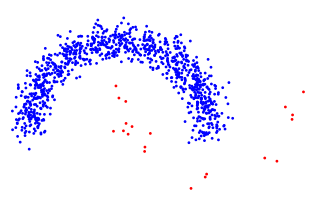

In [248]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = torch.cat(
        [
            torch.pi * torch.rand(n),
            torch.pi * torch.rand(n // 50) + torch.pi,
        ]
    )
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label


samples, labels = two_moons(1000)

plt.figure(figsize=(4, 4))
plt.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
plt.savefig("images/two_moons.png", dpi=300)

In [249]:
nominal = samples[labels == 0]
failure = samples[labels == 1]
failure.shape

torch.Size([20, 2])

In [250]:
# Train single NSF with KL regularization
beta = 0.01
flow_nsf_beta_nominal = zuko.flows.NSF(features=2, hidden_features=(64, 64))
flow_nsf_beta_failure = zuko.flows.NSF(features=2, hidden_features=(64, 64))
nominal_optimizer = torch.optim.Adam(flow_nsf_beta_nominal.parameters(), lr=1e-3)
failure_optimizer = torch.optim.Adam(flow_nsf_beta_failure.parameters(), lr=1e-3)

pbar = tqdm(range(200))
for epoch in pbar:
    nominal_optimizer.zero_grad()
    failure_optimizer.zero_grad()

    loss_nominal = -flow_nsf_beta_nominal().log_prob(nominal).mean()

    loss_nominal.backward()
    nominal_optimizer.step()

    p_dist = flow_nsf_beta_failure()
    q_dist = flow_nsf_beta_nominal()
    p_samples, p_logprobs = p_dist.rsample_and_log_prob((100,))
    q_logprobs = q_dist.log_prob(p_samples)
    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)

    loss_failure = (
        -flow_nsf_beta_failure().log_prob(failure).mean() + beta * kl_divergence
    )
    loss_failure.backward()
    failure_optimizer.step()

    pbar.set_description(
        f"({epoch}) {loss_nominal.detach().item():.3f}, {loss_failure.detach().item():.3f}"
    )

(7) 1.449, 1.899:   4%|▍         | 8/200 [00:00<00:11, 16.63it/s]

(199) 0.295, -1.088: 100%|██████████| 200/200 [00:21<00:00,  9.28it/s]


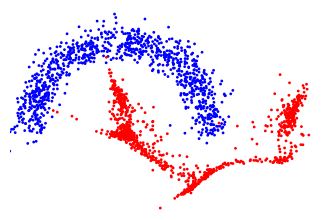

In [251]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
nominal_samples = flow_nsf_beta_nominal().sample((1_000,))
nominal_labels = torch.tensor([0.0]).expand(1_000)
failure_samples = flow_nsf_beta_failure().sample((1_000,))
failure_labels = torch.tensor([1.0]).expand(1_000)
samples = torch.cat((nominal_samples, failure_samples), axis=0)
labels = torch.cat((nominal_labels, failure_labels), axis=0)
ax.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
# plt.savefig('images/two_moons_nsf_context_beta.png', dpi=300)

In [252]:
# Train calibrated NSF
beta = 1.0
n_permutations = 2
permutation_size = int(0.5 * failure.shape[0])
flow_nsf_beta_calibrated_failure = zuko.flows.NSF(
    features=2, context=n_permutations, hidden_features=(64, 64)
)
failure_optimizer = torch.optim.Adam(
    flow_nsf_beta_calibrated_failure.transform.parameters(), lr=1e-3
)

mixture_label = torch.zeros(n_permutations, requires_grad=True)
mixture_label_optimizer = torch.optim.Adam([mixture_label], lr=1e-2)

# Create a set of permuted failure samples
permutation = torch.randperm(failure.shape[0])
failure_permutations = [permutation[:permutation_size], permutation[permutation_size:]]
# failure_permutations = []
# for i in range(n_permutations):
#     failure_permutations.append(torch.randperm(failure.shape[0])[:permutation_size])

pbar = tqdm(range(200))
for epoch in pbar:
    # Train the mixture label
    mixture_label_optimizer.zero_grad()
    mixture_label_loss = -flow_nsf_beta_calibrated_failure(mixture_label).log_prob(
        failure
    ).mean()
    mixture_label_loss.backward()
    mixture_label_optimizer.step()

    failure_optimizer.zero_grad()
    total_failure_loss = torch.tensor(0.0)

    for i in range(n_permutations):
        label = torch.zeros(n_permutations)
        label[i] = 1.0
        total_failure_loss += (
            -flow_nsf_beta_calibrated_failure(label)
            .log_prob(failure[failure_permutations[i]])
            .mean()
            / n_permutations
        )

    # Add the loss for the optimized label
    total_failure_loss += -flow_nsf_beta_calibrated_failure(mixture_label).log_prob(
        failure
    ).mean()

    # # Sample some random labels
    # n_random_labels = 10
    # random_labels = torch.rand(n_random_labels, n_permutations)
    # random_labels = torch.vstack((random_labels, torch.ones(1, n_permutations)))
    # samples = flow_nsf_beta_calibrated_failure(random_labels).rsample((100,))
    # kl_p_base = (
    #     flow_nsf_beta_calibrated_failure(random_labels).log_prob(samples)
    #     - flow_nsf_beta_calibrated_failure.base(random_labels).log_prob(samples)
    # ).mean(dim=0)
    # max_kl = torch.maximum(torch.tensor(1.0), kl_p_base[-1].detach())
    # kl_err = kl_p_base - 10 * torch.norm(random_labels, dim=-1) / n_permutations
    # total_failure_loss += beta * (kl_err ** 2).mean()

    # Also try to reconstruct the nominal with a zero label
    label = torch.zeros(n_permutations)
    total_failure_loss += (
        -flow_nsf_beta_calibrated_failure(label).log_prob(nominal).mean()
        # / n_permutations
    )

    total_failure_loss.backward()
    failure_optimizer.step()

    pbar.set_description(
        f"({epoch}) {loss_nominal.detach().item():.3f}, {total_failure_loss:.3f}"
    )

(0) 0.295, 8.321:   0%|          | 1/200 [00:00<00:21,  9.34it/s]

(199) 0.295, -2.408: 100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


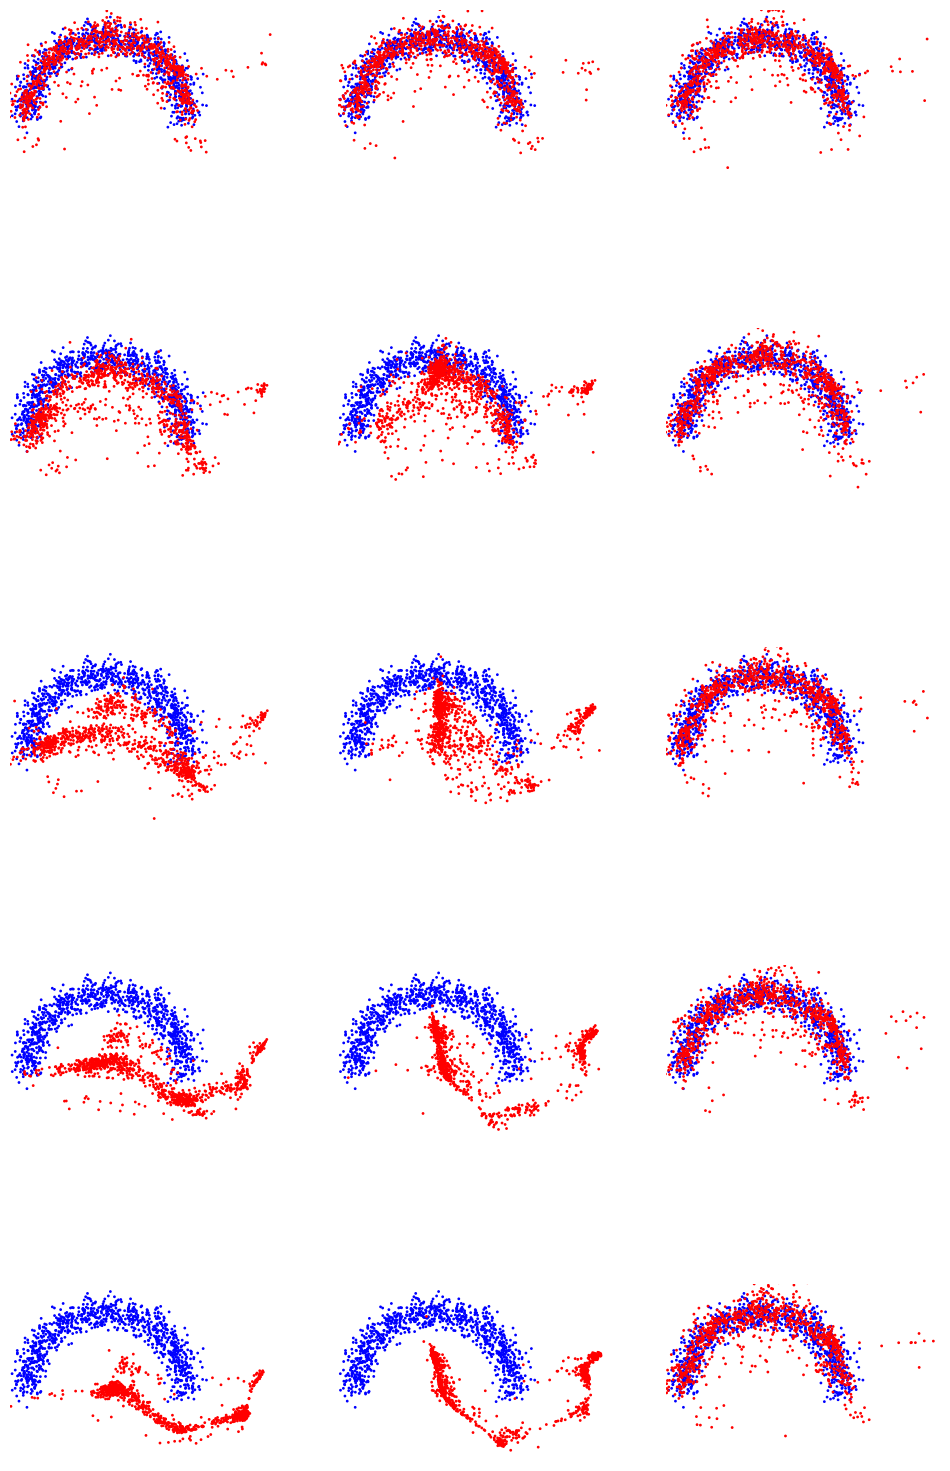

In [253]:
n_steps = 5
_, axs = plt.subplots(n_steps, 1 + n_permutations, figsize=(4 * (1 + n_permutations), 4 * n_steps))
for row, j in enumerate(torch.linspace(0, 1, n_steps)):
    for i in range(n_permutations):
        label = torch.zeros(n_permutations)
        label[i] = j

        nominal_samples = nominal
        nominal_labels = torch.tensor([0.0]).expand(nominal_samples.shape[0])
        failure_samples = flow_nsf_beta_calibrated_failure(label).sample((nominal_samples.shape[0],))
        failure_labels = torch.tensor([1.0]).expand(nominal_samples.shape[0])

        samples = torch.cat((nominal_samples, failure_samples), axis=0)
        labels = torch.cat((nominal_labels, failure_labels), axis=0)
        axs[row, i].scatter(*samples.T, s=1, c=labels, cmap="bwr")
        # Turn off axis ticks
        axs[row, i].set_xticks([])
        axs[row, i].set_yticks([])
        axs[row, i].axis("off")
        axs[row, i].set_ylim([-1.1, 1.1])
        axs[row, i].set_xlim([-1.7, 1.7])
        # Equal aspect
        axs[row, i].set_aspect("equal")
        # plt.savefig('images/two_moons_cnf_stacked.png', dpi=300)

    i = -1
    label = torch.zeros(n_permutations)
    nominal_samples = nominal
    nominal_labels = torch.tensor([0.0]).expand(nominal_samples.shape[0])
    failure_samples = flow_nsf_beta_calibrated_failure(label).sample((nominal_samples.shape[0],))
    failure_labels = torch.tensor([1.0]).expand(nominal_samples.shape[0])

    samples = torch.cat((nominal_samples, failure_samples), axis=0)
    labels = torch.cat((nominal_labels, failure_labels), axis=0)
    axs[row, i].scatter(*samples.T, s=1, c=labels, cmap="bwr")
    # Turn off axis ticks
    axs[row, i].set_xticks([])
    axs[row, i].set_yticks([])
    axs[row, i].axis("off")
    axs[row, i].set_ylim([-1.1, 1.1])
    axs[row, i].set_xlim([-1.7, 1.7])
    # Equal aspect
    axs[row, i].set_aspect("equal")

plt.savefig('images/two_moons_cnf_calibrated_range.png', dpi=300)

In [258]:
# Calibration step: can we optimize the label to maximize performance on the full set?
pbar = tqdm(range(100))
for epoch in pbar:
    mixture_label_optimizer.zero_grad()
    loss = -flow_nsf_beta_calibrated_failure(mixture_label).log_prob(failure).mean()
    loss.backward()
    mixture_label_optimizer.step()
    pbar.set_description(f"({epoch}) {loss.detach().item():.3f}")

print(mixture_label)

(99) -1.111: 100%|██████████| 100/100 [00:04<00:00, 21.80it/s]


tensor([0.2626, 0.7867], requires_grad=True)


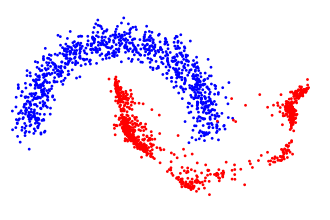

In [259]:
nominal_samples = nominal
nominal_labels = torch.tensor([0.0]).expand(nominal_samples.shape[0])
failure_samples = flow_nsf_beta_calibrated_failure(mixture_label).sample((nominal_samples.shape[0],))
failure_labels = torch.tensor([1.0]).expand(nominal_samples.shape[0])

samples = torch.cat((nominal_samples, failure_samples), axis=0)
labels = torch.cat((nominal_labels, failure_labels), axis=0)

_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
plt.savefig('images/two_moons_nsf_calibrated.png', dpi=300)

Sinkhorn:
	Uncalibrated/Eval: 0.5600694343117858
	Calibrated/Eval: 0.6151791291079445
MMD (0.01):
	Uncalibrated/Eval Sink: 0.04795187711715698
	Calibrated/Eval Sink: 0.08629095554351807
MMD (0.1):
	Uncalibrated/Eval Sink: 0.04795187711715698
	Calibrated/Eval Sink: 0.08629095554351807
MMD (1.0):
	Uncalibrated/Eval Sink: 0.04795187711715698
	Calibrated/Eval Sink: 0.08629095554351807
MMD (10.0):
	Uncalibrated/Eval Sink: 0.04795187711715698
	Calibrated/Eval Sink: 0.08629095554351807
MMD simple:
	Uncalibrated/Eval: 0.040191829204559326
	Calibrated/Eval: 0.07137364149093628
KL(eval || p):
	Uncalibrated: 2.422415256500244
	Calibrated: 1.6492664813995361
KL(p || eval):
	Uncalibrated: 1.1722193956375122
	Calibrated: 1.3547791242599487
H(eval || p):
	Uncalibrated: 2.8423094749450684
	Calibrated: 2.0691606998443604


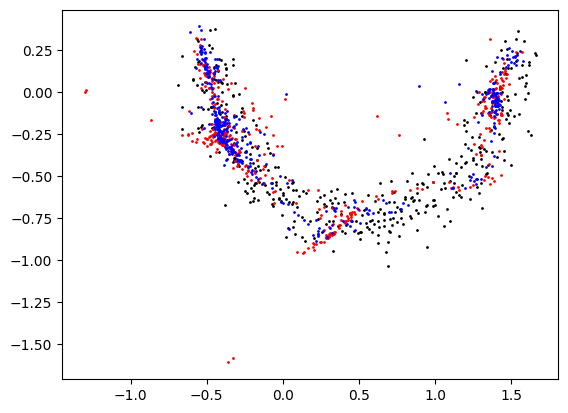

In [260]:
eval_samples, eval_labels = two_moons(20000)
eval_samples = eval_samples[eval_labels == 1]

uncalibrated_samples = flow_nsf_beta_failure().sample((eval_samples.shape[0],))
calibrated_samples = flow_nsf_beta_calibrated_failure(mixture_label).sample((eval_samples.shape[0],))

plt.scatter(*eval_samples.T, s=1, c="k", label="True")
plt.scatter(*uncalibrated_samples.T, s=1, c="r", label="Uncalibrated")
plt.scatter(*calibrated_samples.T, s=1, c="b", label="Calibrated")

print("Sinkhorn:")
print(f"\tUncalibrated/Eval: {sinkhorn(uncalibrated_samples, eval_samples)}")
print(f"\tCalibrated/Eval: {sinkhorn(calibrated_samples, eval_samples)}")

for x in [0.01, 0.1, 1.0, 10.0]:
    loss = MMDLoss(RBF(n_kernels=1, mul_factor=x))
    print(f"MMD ({x}):")
    print(f"\tUncalibrated/Eval Sink: {loss(uncalibrated_samples, eval_samples)}")
    print(f"\tCalibrated/Eval Sink: {loss(calibrated_samples, eval_samples)}")

print("MMD simple:")
print(f"\tUncalibrated/Eval: {simple_mmd(uncalibrated_samples, eval_samples)}")
print(f"\tCalibrated/Eval: {simple_mmd(calibrated_samples, eval_samples)}")

samples = flow_failure_eval().sample((1_000,))
kl_eval_uncalibrated = (
    flow_failure_eval().log_prob(eval_samples)
    - flow_nsf_beta_failure().log_prob(eval_samples)
).mean()
kl_eval_calibrated = (
    flow_failure_eval().log_prob(eval_samples)
    - flow_nsf_beta_calibrated_failure(mixture_label).log_prob(eval_samples)
).mean()
print("KL(eval || p):")
print(f"\tUncalibrated: {kl_eval_uncalibrated}")
print(f"\tCalibrated: {kl_eval_calibrated}")

samples = flow_nsf_beta_failure().sample((1_000,))
kl_uncalibrated_eval = (
    flow_nsf_beta_failure().log_prob(samples)
    - flow_failure_eval().log_prob(samples)
).mean()
samples = flow_nsf_beta_calibrated_failure(mixture_label).sample((1_000,))
kl_calibrated_eval = (
    flow_nsf_beta_calibrated_failure(mixture_label).log_prob(samples)
    - flow_failure_eval().log_prob(samples)
).mean()
print("KL(p || eval):")
print(f"\tUncalibrated: {kl_uncalibrated_eval}")
print(f"\tCalibrated: {kl_calibrated_eval}")

ce_eval_uncalibrated = -(
    flow_nsf_beta_failure().log_prob(eval_samples)
).mean()
ce_eval_calibrated = -(
    flow_nsf_beta_calibrated_failure(mixture_label).log_prob(eval_samples)
).mean()
print("H(eval || p):")
print(f"\tUncalibrated: {ce_eval_uncalibrated}")
print(f"\tCalibrated: {ce_eval_calibrated}")

/tmp/ipykernel_3360974/2237844351.py:5: UserWarning: linewidths is ignored by contourf
  plt.tricontourf(label_space[:, 0, 0], label_space[:, 0, 1], calibrated_logprobs, levels=100, linewidths=0.5, cmap="magma")


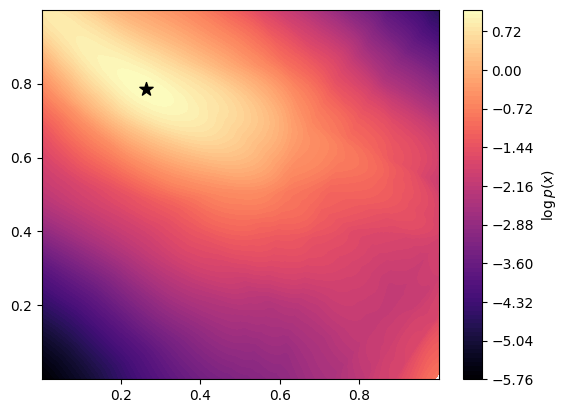

In [261]:
with torch.no_grad():
    label_space = torch.rand(100_000, 1, n_permutations)
    label_space[:, :, 2:] = mixture_label[2:]
    calibrated_logprobs = flow_nsf_beta_calibrated_failure(label_space).log_prob(failure).mean(dim=-1)
    plt.tricontourf(label_space[:, 0, 0], label_space[:, 0, 1], calibrated_logprobs, levels=100, linewidths=0.5, cmap="magma")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("$\log p(x)$")
    plt.scatter(*mixture_label[:2].detach().numpy().T, s=100, c="k", marker="*")
    plt.savefig("images/two_moons_calibration_landscape.png", dpi=300)